# Week 2: MFCCs and HMMs
This week we're moving on to how to apply sequence models to decode speech. To do this, we'll introduce a model that's closely related to the WFST, namely the *Hidden Markov Model*. We'll start with a simple analogy involving geography and pathfinding in order to understand the intuition behind the model. We'll use the `pomegranate` library for modeling HMMs, though HMMs can also be converted into WFSTs, which we'll demonstrate using `pynini`.

After that, we'll review how we can use MFCCs to represent speech in a numerical form that's useful for machine learning, and then use this to apply HMMs to speech. We'll use `librosa`, a Python library for handling audio, to calculate MFCCs.

In [9]:
import librosa
from pympi import Praat
import pandas as pd
import numpy as np
import sklearn.manifold
import matplotlib.pyplot as plt
import seaborn as sns
from pomegranate.hmm.sparse_hmm import SparseHMM
from pomegranate.distributions import Categorical
import pynini

## Section 1: Navigating a map with HMMs
HMMs are a Markov sequence model like WFSTs. Like WFSTs, HMMs have various states that are linked by connecting arcs where each arc is associated with a weight. The key difference between WFSTs and HMMs lies in the separation of states from *observations* in the latter.

In FSTs, we traverse the graph by consuming a sequence of letters, i.e. the input word. Let $W$ be the input word and $w_i$ be the $i^{th}$ letter in the input word. At each point we can transition from the current state $n$ to state $m$ if there is an arc between $n$ and $m$ that consumes the letter $w_i$. Thus, the letters dictate which states we visit as we draw a path through the FST.

In HMMs, we traverse the graph by instead consuming *observations*. Each state in the HMM has a certain probability of 'emitting' an observation. Each state also has a certain probability of *transitioning* to another state. This can be best illustrated with an example.

Imagine we are navigating between three states, where here 'state' is a literal state of the United States of America. In this version of America, the states of Texas, California and Alaska are all geographically contiguous, so we can walk from one straight into the other. Also in this America, there are no signs or overt indicator of which state we are in. We don't see a "Welcome to California" sign when we cross from Texas into California. What we do see, though, are geographical features, in particular snow, beaches or oil rigs.

![HMM example](media/hmm.svg)

There are more oil rigs in Texas than in the other two, there beaches in California than the other two, and there is more snow in Alaska than the other two. Thus, if we observe a lot of oil rigs, but few beaches and no snow, then there's a good chance we're in Texas. As soon as we start seeing a lot of beaches, there's a good chance we've made it to California. However, if we observe a lot of oil rigs, a single beach, and then more oil rigs, it's likely we stayed in Texas the whole time. That's because, even if it's more probable that you'll see a beach in California, we still need to *transition* from Texas to California, and after seeing a single beach it's more likely that we happened on a beach in Texas than we happened to transition from Texas to California.

These probabilities are represented by the color and thickness of the arrows in the graph above. A thick red line indicates high probability and a thin blue line low probability. The observation probabilities of oil rig, snow and beach are not the only thing that differentiates the different states. They also have different transition probabilities. The probability of transitioning from California to Texas is very high: Californian's want lower rent and gas. The probability of transitioning from Texas to California is a bit lower. Alaska is harder to get to, even though, for the sake of this metaphor, it's possible to walk there. Because of that, transition probabilities into and out of Alaska are lower than they are between California and Texas.

In [ ]:
observations = ["snow", "oilrig", "beach"]
snow = observations.index('snow')
oilrig = observations.index('oilrig')
beach = observations.index('beach')

texas = Categorical([[0.1, 0.7, 0.2]])
cali = Categorical([[0.3, 0.1, 0.6]])
alaska = Categorical([[0.7, 0.2, 0.1]])
states = [texas, cali, alaska]

hmm = SparseHMM(distributions=states)

hmm.add_edge(hmm.start, texas, 0.4)
hmm.add_edge(hmm.start, cali, 0.4)
hmm.add_edge(hmm.start, alaska, 0.2)

hmm.add_edge(texas, texas, 0.7)
hmm.add_edge(texas, cali, 0.2)
hmm.add_edge(texas, alaska, 0.1)

hmm.add_edge(cali, cali, 0.5)
hmm.add_edge(cali, texas, 0.4)
hmm.add_edge(cali, alaska, 0.1)

hmm.add_edge(alaska, alaska, 0.85)
hmm.add_edge(alaska, texas, 0.05)
hmm.add_edge(alaska, cali, 0.1)

hmm.edges

[(Silent(), Categorical(), 0.4),
 (Silent(), Categorical(), 0.4),
 (Silent(), Categorical(), 0.2),
 (Categorical(), Categorical(), 0.7),
 (Categorical(), Categorical(), 0.2),
 (Categorical(), Categorical(), 0.1),
 (Categorical(), Categorical(), 0.5),
 (Categorical(), Categorical(), 0.4),
 (Categorical(), Categorical(), 0.1),
 (Categorical(), Categorical(), 0.85),
 (Categorical(), Categorical(), 0.05),
 (Categorical(), Categorical(), 0.1)]

In [25]:
observation_vector = [[[beach], [beach], [beach], [snow]]]
hmm.viterbi(observation_vector)

tensor([[1, 1, 1, 0]])

## Section 2: Encoding audio with MFCCs

In [161]:
wav_path = 'data/ailn.wav'
textgrid_path = 'data/ailn.TextGrid'

In [162]:
wav, samplerate = librosa.load(wav_path)
wav.shape, samplerate

((190560,), 22050)

In [163]:
textgrid = Praat.TextGrid(textgrid_path)

In [164]:
rows = []
for tier in textgrid.tiers:
    for start, end, value in tier.get_intervals():
        if not value:
            continue
        rows.append({'start': start, 'end': end, 'value': value, 'tier': tier.name})
df = pd.DataFrame(rows)
df.head()

,start,end,value,tier
0,1.936085,2.017377,l,phone
1,2.017377,2.248902,a,phone
2,2.248902,2.408397,n,phone
3,3.012286,3.106954,l,phone
4,3.106954,3.378611,i,phone


In [165]:
df['start_sample'] = (df['start']*samplerate).astype(int)
df['end_sample'] = (df['end']*samplerate).astype(int)
df.head()

,start,end,value,tier,start_sample,end_sample
0,1.936085,2.017377,l,phone,42690,44483
1,2.017377,2.248902,a,phone,44483,49588
2,2.248902,2.408397,n,phone,49588,53105
3,3.012286,3.106954,l,phone,66420,68508
4,3.106954,3.378611,i,phone,68508,74498


In [166]:
mfcc_matrix = librosa.feature.mfcc(y=wav, sr=samplerate, n_mfcc=13)
mfcc_matrix.shape

(13, 373)

In [167]:
mfcc_window_count = mfcc_matrix.shape[1]
num_samples = wav.shape[0]
samples_per_mfcc_window = num_samples//mfcc_window_count
samples_per_mfcc_window

510

In [168]:
df['mfcc_index_start']=df['start_sample']//samples_per_mfcc_window
df['mfcc_index_end']=df['end_sample']//samples_per_mfcc_window-1

df.head()

,start,end,value,tier,start_sample,end_sample,mfcc_index_start,mfcc_index_end
0,1.936085,2.017377,l,phone,42690,44483,83,86
1,2.017377,2.248902,a,phone,44483,49588,87,96
2,2.248902,2.408397,n,phone,49588,53105,97,103
3,3.012286,3.106954,l,phone,66420,68508,130,133
4,3.106954,3.378611,i,phone,68508,74498,134,145


In [169]:
phoneme2index = {'nonspeech': 0, 'a': 1, 'i': 2, 'l': 3, 'n': 4}
index2phoneme = {value:key for key, value in phoneme2index.items()}
mfcc_phoneme_ids = np.zeros(mfcc_window_count)

def set_mfcc_phoneme_ids(row):
    mfcc_phoneme_ids[row['mfcc_index_start']:row['mfcc_index_end']]=phoneme2index[row['value']]

df[df['tier']=='phone'].apply(set_mfcc_phoneme_ids, axis=1)
mfcc_phoneme_ids

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3.,
       3., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 4., 4., 4., 4., 4.,
       4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 0., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 4., 4., 4., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 4., 4., 4., 4., 0.,
       2., 2., 2., 2., 2., 2., 0., 3., 3., 3., 3., 3., 3., 3., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Let's visualize the MFCCs using `t-SNE`

In [170]:
mfcc_tsne = sklearn.manifold.TSNE().fit_transform(mfcc_matrix.T)
mfcc_tsne.shape

(373, 2)

In [171]:
tsne_df = pd.DataFrame(mfcc_tsne)
tsne_df['phoneme']=mfcc_phoneme_ids
tsne_df['phoneme']=tsne_df['phoneme'].map(index2phoneme)
tsne_df.head()

,0,1,phoneme
0,12.340375,-0.410551,nonspeech
1,11.665703,0.109347,nonspeech
2,-5.458351,5.690603,nonspeech
3,-12.369607,6.142801,nonspeech
4,-25.318262,5.181537,nonspeech


In [172]:
speech_mask = tsne_df['phoneme']!='nonspeech'

<Axes: xlabel='0', ylabel='1'>

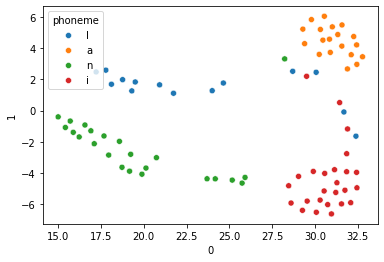

In [173]:
sns.scatterplot(tsne_df[speech_mask], x=0, y=1, hue='phoneme')